Repositório do modelo BERT pré-treinado da **neuralmind.ia** para a língua portuguesa

https://github.com/neuralmind-ai/portuguese-bert

# **1. Bibliotecas requeridas**

In [ ]:
import warnings
import pandas as pd
import logging
import re
import numpy as np
import seaborn as sns

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

from simpletransformers.classification import ClassificationModel

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import precision_score as pr
from sklearn.metrics import recall_score as rec
from sklearn.metrics import f1_score as f1
from sklearn.metrics import roc_auc_score as auc 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# **2. Leitura do Dataset**

In [42]:
prefix_path = '/home/lucas/sentiment-analysis/'

In [46]:
prefix_path = '/home/lucas/Documentos/Cursos/Pos-Graduacao/PUC_MG/TCC/code/sentiment-analysis/'

In [47]:
# Cria o dataframe com os datasets já concatenados
df_datasets = pd.read_csv(prefix_path + 'datasets/dataset_concat.csv', sep = ';', encoding = 'utf-8')

# transforma os dados da coluna "text" para string
df_datasets['text'] = df_datasets['text'].astype(str)

In [48]:
# Verifica a quantidade de amostras no df_datasets
df_datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68461 entries, 0 to 68460
Data columns (total 2 columns):
text      68461 non-null object
labels    68456 non-null object
dtypes: object(2)
memory usage: 1.0+ MB


In [49]:
# Verifica a quantidade de registros únicos para a coluna "labels"
df_datasets['labels'].nunique()

3

In [50]:
# Verifica quais são os registros únicos para a coluna "labels"
df_datasets.labels.unique()

array(['Neutro', 'Positivo', 'Negativo', nan], dtype=object)

# **3. Pré-processamento dos dados** 

In [15]:
# Descarta as amostras que possuem a label "Neutro"
df_datasets = df_datasets[df_datasets.labels != 'Neutro']

# Remove os registros que possuem o valor "null" para a coluna "labels"
df_datasets = df_datasets[df_datasets.labels.notnull()]

In [16]:
# Verificando quais são os registros únicos após a remoção do valor "Neutro"
df_datasets.labels.unique()

array(['Positivo', 'Negativo'], dtype=object)

In [17]:
# Verificando a quantidade de amostras por classe (labels)
df_datasets['labels'].value_counts()

Negativo    25941
Positivo    19389
Name: labels, dtype: int64

In [22]:
# Reiniciando os índices após a exclusão nos passos anteriores
df_datasets.reset_index(drop=True, inplace=True)

#### **3.1. Substituição dos valores "Positivo" e "Negativo" para 0 e 1, respectivamente.**

In [23]:
df_datasets['labels'].replace(to_replace=['Positivo'], value=0, inplace=True)
df_datasets['labels'].replace(to_replace=['Negativo'], value=1, inplace=True)

In [24]:
df_datasets.head()

,text,labels
0,Parem de olhar para o meu telemovel quando est...,0
1,RT @fabionaoseique: http://t.co/cAajp1yqbD Est...,0
2,Gostei de um vídeo do @YouTube http://t.co/PQW...,0
3,É indigno e vergonhoso corte das pensões de so...,1
4,"Atenção!!!\r\nCozinheiros, chefes, apreciadore...",0


#### **3.2. Divisão do dataset para bases de treino e teste**

In [25]:
train, test = train_test_split(df_datasets, test_size=0.30, 
                               random_state=42, shuffle=True)

In [26]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31731 entries, 0 to 31730
Data columns (total 2 columns):
text      31731 non-null object
labels    31731 non-null int64
dtypes: int64(1), object(1)
memory usage: 495.9+ KB


In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13599 entries, 0 to 13598
Data columns (total 2 columns):
text      13599 non-null object
labels    13599 non-null int64
dtypes: int64(1), object(1)
memory usage: 212.6+ KB


#### **3.3. Exportando as bases de treino e teste após a execução das etapas anteriores**

In [34]:
train.to_csv(prefix_path + '/datasets/treino.csv', header=True, index=False, sep=';', encoding='utf-8')
test.to_csv(prefix_path + '/datasets/teste.csv', header=True, index=False, sep=';', encoding='utf-8')

#### **3.4. Importando as bases que foram exportadas na etapa anterior**

In [35]:
df_treino = pd.read_csv(prefix_path + '/datasets/treino.csv', sep=';', encoding='utf-8')

In [36]:
df_treino['labels'].value_counts()

1    18139
0    13592
Name: labels, dtype: int64

#### **3.5. Criando um novo dataframe com as classes balanceadas**

Utilizando o método groupby e aplicando uma função lambda para capturar a quantidade limitada de 13000 amostras por classe.

In [37]:
n_samples = 13000
new_df_treino = df_treino.groupby('labels').apply(lambda x: x.sample(n=n_samples)).reset_index(drop = True)

In [38]:
new_df_treino.head()

,text,labels
0,Poucas são as mulheres que me fazem soltar um ...,0
1,E já tenho o meu Galaxy Star. É lindo como tudo!,0
2,umas ferias de 1 mes ou 2 vinham mesmo a calha...,0
3,@AgostinhoIsabel espero bem que sim!,0
4,RT @agenciabrasil: Rio distribui vacinas contr...,0


#### **3.6. Removendo Links e URLS**

In [39]:
def remove_handlers(text):
    url = re.compile(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|
                    \(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''')
    return url.sub(r"", text)

In [40]:
# aplica a função remove_handlers para o novo dataframe de treino balanceado
new_df_treino['text'] = [remove_handlers(entry) for entry in new_df_treino['text']]

In [41]:
new_df_treino.head()

,text,labels
0,Poucas são as mulheres que me fazem soltar um ...,0
1,E já tenho o meu Galaxy Star. É lindo como tudo!,0
2,umas ferias de 1 mes ou 2 vinham mesmo a calha...,0
3,@AgostinhoIsabel espero bem que sim!,0
4,RT @agenciabrasil: Rio distribui vacinas contr...,0


## **4. Treino do Modelo**

**Criação do objeto KFold para realizar o treino do modelo utilizando o cross-validation**

In [ ]:
# 10 folds
n = 10

# Criação da instância do KFold para realizar o cross-validation durante o treino do modelo
kf = KFold(n_splits=n, random_state=1, shuffle=True)

#### **4.1. A biblioteca SimpleTransformers necessita da definição de um dicionário contendo os parâmetros utilizandos durante o treinamento. O mesmo foi definido abaixo como "train_args**.

In [ ]:
# Parâmetros para treinamento

train_args={
    'reprocess_input_data': False,
    'overwrite_output_dir': True,
    'max_seq_length': 128,
    'fp16': True,
    "train_batch_size": 32,
    "eval_batch_size": 32,
    'gradient_accumulation_steps': 1,
    'weight_decay': 0,
    "learning_rate": 4e-05,
    'adam_epsilon': 1e-08,
    'num_train_epochs': 1,
    'evaluate_during_training': True,
    'use_multiprocessing': False,
    'do_lower_case': False,
    'no_cache': True,
    'manual_seed': 1,
    'output_dir': '/prefix_path/ciclo_01',
    'best_model_dir':'/prefix_path/ciclo_01/modelo_vencedor',
    'evaluate_during_training_verbose': True,
    'save_eval_checkpoints': False,
    'save_model_every_epoch': False,
    'strip_accents' : True
}

#### **4.2. Carrega o modelo BERT pré-treinado Bertimbau da língua portuguesa.**

O parâmetro "num_labels" indica a quantidade de labels possível, neste caso é um modelo binário.

O parâmetro "usa_cuda" é um parâmetro booleano que define se irá utilizar ou não GPU para o treinamento.

In [ ]:
model = ClassificationModel('bert', '/prefix_path/BertimbauCasedFT', args=train_args, num_labels=2, use_cuda=True)

#### **4.2. A seguir será iniciado o treino do modelo utilizando cross-validation**

In [ ]:
results = []

for train_index, eval_index in kf.split(new_df_treino):
    
    train_df = new_df_treino.iloc[train_index]
    eval_df = new_df_treino.iloc[eval_index]
    
    train_df['text'] = train_df['text'].astype(str)
    eval_df['text'] = eval_df['text'].astype(str)
    eval_df["text"] = eval_df["text"].tolist() 
    
    # train the model
    model.train_model(train_df, eval_df=eval_df)
    
    # validate the model
    result, model_outputs, wrong_predictions = model.eval_model(eval_df, 
                                                                acuracia=acc, 
                                                                precisao=pr,
                                                                recall=rec, 
                                                                f1=f1, 
                                                                auc=auc)
    
    # append model score
    results.append(result)

## **5. Avaliação do Modelo**

#### **5.1. Importação da base de teste para verificar a performance do modelo.**

In [31]:
# carrega a base de treino
df_teste = pd.read_csv(prefix_path + 'prefix_path/datasets/teste.csv', sep = ';', encoding = 'utf-8')

# transforma os dados da coluna "text" em string
df_teste['text'] = df_teste['text'].astype(str)

# transforma as mensagens em lista.(Este é o formato aceito)
df_teste["text"] = df_teste["text"].tolist() 

In [32]:
df_teste['text'] = [remove_handlers(entry) for entry in df_teste['text']]

In [33]:
df_teste.head()

,text,labels
0,"JA SAIU O EP. 2 DE AMERICAN HORROR STORY, XAU",0
1,"Tenho um feitio super complicado, admito.",0
2,Até amanhã a todos.,1
3,"Quanto mais estudo matematica, menos percebo d...",1
4,@Le_Bundaaa obrigada ^^,0


In [42]:
df_teste['labels'].value_counts()

1    7802
0    5797
Name: labels, dtype: int64

##### **5.2. Criando um novo dataframe de teste com as classes balanceadas**

Utilizando o método groupby e aplicando uma função lambda para capturar a quantidade limitada de 5000 amostras por classe.

In [ ]:
n_samples = 5000
df_teste = df_teste.groupby('labels').apply(lambda x: x.sample(n=n_samples)).reset_index(drop = True)

In [35]:
# Carrega o modelo vencedor que obteve os melhores resultados
modelo_vencedor = ClassificationModel('bert', '/prefix_path/ciclo_01/modelo_vencedor', args=train_args, use_cuda=True)

In [36]:
# Realiza a inferência na base de teste balanceada
predictions, raw_outputs = modelo_vencedor.predict(df_teste["text"])

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [37]:
# Inclui as inferências no dataframe de teste
df_teste["predict"] = pd.DataFrame(predictions) 
df_teste.head()

,text,labels,predict
0,"JA SAIU O EP. 2 DE AMERICAN HORROR STORY, XAU",0,0
1,"Tenho um feitio super complicado, admito.",0,0
2,Até amanhã a todos.,1,0
3,"Quanto mais estudo matematica, menos percebo d...",1,1
4,@Le_Bundaaa obrigada ^^,0,0


##### **5.3. O método "eval_model" calcula métricas de acordo com as predições realizadas, verificando as colunas "labels" e "predict" do dataframe informado.**

In [38]:
result, model_outputs, wrong_predictions = modelo_vencedor.eval_model(df_teste, 
                                                                      acuracia=acc, 
                                                                      precisao=pr, 
                                                                      recall=rec, 
                                                                      f1=f1, 
                                                                      auc=auc)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.5089502932710943, 'tp': 5532, 'tn': 4669, 'fp': 1128, 'fn': 2270, 'acuracia': 0.7501286859327891, 'precisao': 0.8306306306306306, 'recall': 0.7090489618046655, 'f1': 0.765039413635735, 'auc': 0.7572327782975371, 'eval_loss': 1.0486787713275236}


#### **5.4. Visualização dos resultados utilizando a matriz de confusão**

In [39]:
conf_matrix = confusion_matrix(df_teste["labels"], df_teste["predict"])
print(conf_matrix)

[[4669 1128]
 [2270 5532]]


In [40]:
print(classification_report(df_teste["predict"], df_teste["labels"]))

              precision    recall  f1-score   support

           0       0.81      0.67      0.73      6939
           1       0.71      0.83      0.77      6660

    accuracy                           0.75     13599
   macro avg       0.76      0.75      0.75     13599
weighted avg       0.76      0.75      0.75     13599



#### **5.5. Incrementando a matriz de confusão para facilitar a verificação dos resultados obtidos**

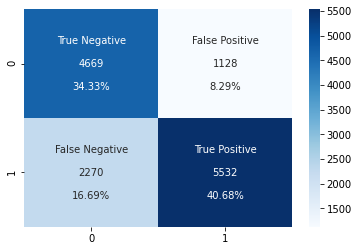

In [41]:
group_names = ['True Negative','False Positive','False Negative','True Positive']

group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]

labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues');